In [ ]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
from torch import Tensor
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy


#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
  print(torch.cuda.get_device_name(0))

torch.manual_seed(1234)

np.random.seed(1234)

cuda


In [ ]:
#The sine activation function
class sine(torch.nn.Module):
  @staticmethod
  def forward(input):
    return torch.sin(input)

#Automatic differentiation in pytorch
def dfx(f,x):
  gouts = torch.ones(x.shape, dtype=torch.float, device = device)
  return grad([f],[x],grad_outputs=gouts, create_graph=True)[0]

In [ ]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t,nn,t0,tf, bound):
  N1 = nn(t)
  dt1 = t - t0
  dt2 = t - tf
  f = (1-torch.exp(-dt1))*(1-torch.exp(dt2))
  psi_hat = bound + f*N1
  return psi_hat

In [ ]:
def hamEqs_Loss(t,psi, pot,iter,V_max,breakpoints,E_count):
  if iter < 5000:
    psi_init = torch.exp(-t**2)
    f = psi - psi_init
    L = (f.pow(2)).mean()
    return L
  else:
    psi_x = dfx(psi,t)
    psi_xx = dfx(psi_x,t)
    E  = ((torch.dot(psi[:,0], -0.5*psi_xx[:,0] + pot[:,0] * psi[:,0]))/(torch.dot(psi[:,0],psi[:,0]))) ####
    discrete_loss = 10*torch.exp(E-V_max)*torch.clamp(torch.sign(E - V_max), min=0)
    f = (-0.5*(psi_xx) + (pot - E)*psi)/torch.sqrt(torch.dot(psi[:,0],psi[:,0]))
    L = (f.pow(2)).mean()
    return L,E, discrete_loss

In [ ]:
#defining the potential
def V(x):
  x = x.data.numpy()
  x0 = 5
  vnp = (np.heaviside(-x-x0,0) + np.heaviside(x-x0,0))*10
  return torch.from_numpy(vnp)

In [ ]:
#Defining the NN architecture without symmetry
class qNN(torch.nn.Module):
  def __init__(self,layers):
    super(qNN,self).__init__()
    self.activation = sine()

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    #self.batch_norms = nn.ModuleList([nn.BatchNorm1d(layers[i+1]) for i in range(len(layers) - 2)])

    #Initializing the weights
    #self.apply(weights_init)
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    #In1 = self.ein(torch.ones_like(a))
    for i in range(len(self.linears)-1):
      z = self.linears[i](a)
      #z = self.batch_norms[i](z)
      a = self.activation(z)

    a = self.linears[-1](a)
    return a

In [ ]:
def points_inside_well(x):
  x = x.detach().cpu().numpy()
  PIW = np.heaviside(x-5,0) + np.heaviside(-x-5,0)
  return abs(PIW -1)

In [ ]:
#Defining the hyperparameters
t0 =-20; tf = 20; xbc = 0; layers = [1,100,100,1]; lr = 1e-2; epochs = 60000
breakpoints =[15000,30000]; col_pts = 201

In [ ]:
def save_checkpoint(state, filename):
  print('=========================')
  print('Saving checkpoint')
  print('=========================')
  torch.save(state, filename)

In [ ]:
#To learn multiple eigenvlues and eigenvectors, we will need both the orthogonality and orthonormality ppty
def nn_train(qNN,t0,tf,xbc,col_pts,breakpoints, epochs,grid,path_loc):
  En_history = [] #To store the eigenvalues as it is optimized
  SE_loss_hist = [] #To store the pde loss
  internal_loss_hist = [] #To compute loss for rolling mean
  Loss_hist = []#To store the total loss after every epoch
  #grid = torch.tensor(xshift).unsqueeze(1).float() #The collocation points
  t_rand = grid.to((device))
  t_rand.requires_grad =True
  t_plot = t_rand.cpu().detach().numpy() #For training plots
  orth_counter = 0
  En_counter = []
  #Dictionary for storing the learned eigenfunction
  dic = {}
  load_model = False #To load the model from the last checkpoint

  stime = time.time()
  if load_model:
    print('=========================')
    print('Loading checkpoint')
    print('=========================')
    checkpoint = torch.load(path_loc)
    qNN.load_state_dict(checkpoint['state_dict']); optimizer.load_state_dict(checkpoint['optimizer'])
    current = checkpoint['epoch']; orth_counter = checkpoint['orth_counter']; Loss_hist = checkpoint['Loss_hist']
    En_history = checkpoint['En_history'];dic = checkpoint['dic']; En_counter = checkpoint['En_counter']
    print('=========================')
    print('Loaded checkpoint')
    print('=========================')
  else:
    current = 0
  #for iter in range(current+1,epochs + 1): #Comment this line if load_model = False
  for iter in range(epochs + 1): #Comment this line if True
    NN = qNN(t_rand) #The forward pass
    loss = 0.0
    #Getting the parametric solution
    psi = parametricSolutions(t_rand,qNN,t0,tf,xbc).to(device)
    psi = psi#/torch.sqrt(torch.dot(psi[:,0],psi[:,0])) #Normalizing psi
    Vx = V(t_rand.cpu()).to(device)



    #Derivatives needed when computing en_loss
    psi_x = dfx(psi,t_rand)
    psi_xx = dfx(psi_x,t_rand)

    if iter < 5000:
      total_loss = hamEqs_Loss(t_rand,psi, Vx,iter,V_max,breakpoints,En_counter)
      if iter % 300 == 0:
        print('--------------------------------------------')
        print('Epoch: ', iter)
        print('loss = ', total_loss.cpu().detach().numpy())
      if iter == 4900:
        checkpoint = {'psi': psi}
        save_checkpoint(checkpoint,'psi.pth.tar')
    else:
      pde_loss, En, discreete_loss = hamEqs_Loss(t_rand,psi, Vx,iter,V_max,breakpoints,En_counter)
      En_history.append(En.cpu().detach().numpy().item())
      #Getting the loss after the forward pass
      SE_loss_hist.append(pde_loss)
      internal_loss_hist.append(pde_loss.cpu().detach().numpy())
      #The loss for the patience condition
      criteria_loss = 100*pde_loss


      #Adding the normalization as a regularization term
      NT = ( 1 - ((tf - t0) * torch.sqrt(torch.dot(psi[:,0],psi[:,0]))/ col_pts) ).pow(2)
      #Adding the nodal loss
      piw = torch.tensor(points_inside_well(t_rand)).to(device) #To remove the oscillations outside the well
      #node1_loss = torch.dot(psi[:,0],psi[:,0])*abs((torch.sum(abs(torch.diff(torch.sign(torch.diff(psi[:,0]*piw[:,0])))/2)) - 2)) #loss of the peaks
      node1_loss = 10*abs((torch.sum(abs(torch.diff(torch.sign(torch.diff(psi[:,0]*piw[:,0])))/2)) - 2))
      total_loss = NT + node1_loss + criteria_loss + discreete_loss





    #if iter == current + 1:
    #  qNN.apply(weights_init)

      for index, breakpoint in enumerate(breakpoints):
        if iter == breakpoint and orth_counter == index:
          dic[index] = copy.deepcopy(qNN)
          En_counter.append(En_history[-1])
          orth_counter += 1
          psi_i = parametricSolutions(t_rand, dic[index],t0,tf,xbc)
          psi = psi_i * (t_rand) # max is at 0
          print('==========================================')
          print(f"Learned {index+1} Eigenvalues")
          print('==========================================')
          #saving a checkpoint for future iterations
          checkpoint = {
              'state_dict': qNN.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': iter, 'Loss_hist': Loss_hist,
              'orth_counter': orth_counter, 'En_history': En_history, 'dic': dic, 'En_counter': En_counter
          }
          save_checkpoint(checkpoint,path_loc)



      #Calculating condition for the lossses
      #Getting the condition for the en_loss
      if orth_counter > 0:
        diff = ((torch.dot(psi[:,0], -0.5*psi_xx[:,0] + Vx[:,0] * psi[:,0]))/(torch.dot(psi[:,0],psi[:,0]))) - En_counter[-1]
        #en_loss = 0 if diff > 0 else 5*torch.exp(-diff)
        en_loss = 5*torch.clamp(torch.sign(-diff), min=0)*torch.exp(-diff)
        ortho_loss = 0

        #Normalizing the orthogonal loss
        for i in range(orth_counter):
          psi_i = parametricSolutions(t_rand,dic[i],t0,tf,xbc)[:,0]
          ortho = torch.sqrt(torch.dot(psi_i, psi[:,0]).pow(2))/ (torch.sqrt(torch.dot(psi_i, psi_i) * torch.sqrt(torch.dot(psi[:,0], psi[:,0]))))
          ortho_loss += ortho
        noden_loss = 10*abs((torch.sum(abs(torch.diff(torch.sign(torch.diff(psi[:,0]*piw[:,0]))))/2) - 2 - orth_counter))
        total_loss +=  ortho_loss/8 + en_loss + noden_loss - node1_loss


      if iter % 300 == 0:
        #Plot the network after every 300 iterations
        #fig,ax1 = plt.subplots(figsize=(4,3))
        #psi_plot = psi.cpu().detach().numpy()
        #ax1.plot(t_plot, psi_plot, label= f'Total_loss: {total_loss.cpu().detach().numpy():.5f} ')
        #ax1.set_title(f'Epoch: {iter}, En: {En_history[-1]:.7f}, oc: {orth_counter}')
        #ax1.legend()
        #plt.show()
        print('--------------------------------------------')
        print('Epoch: ', iter)
        print('En: ', En_history[-1])
        print('oc: ', orth_counter)
        print('--------------------------------------------')
        print('Total_loss: ',total_loss.cpu().detach().numpy())
        if orth_counter > 0:
          print('ortho_loss: ', ortho_loss.cpu().detach().numpy())
          print('en_loss: ',en_loss.cpu().detach().numpy())
        print('pde_loss: ', criteria_loss.cpu().detach().numpy())
        print('NT: ', NT.cpu().detach().numpy())
        print('nodal_loss1: ',node1_loss.cpu().detach().numpy()) if orth_counter == 0 else print('nodal_lossn: ',noden_loss.cpu().detach().numpy())
        print('Discrete loss: ', discreete_loss.cpu().detach().numpy())

        #for name, param in qNN.named_parameters():
        #  if param.grad is not None:
        #    print(f'Parameter: {name}, Gradient Norm: {torch.norm(param.grad)}')

    #Backward propagation
    optimizer.zero_grad()
    total_loss.backward()
    #Introducing Gradient clipping
    #max_norm =5.0
    #torch.nn.utils.clip_grad_norm_(qNN.parameters(), max_norm)
    optimizer.step()
    loss += total_loss.cpu().detach().numpy()


    #Storing the loss after each iteration
    Loss_hist.append(loss)
    #Scheduling the learning rate
    #scheduler.step(total_loss)


  #Storing the final eigenfunction and eigenvalue
  dic[orth_counter] = copy.deepcopy(qNN)
  En_counter.append(En_history[-1])


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return Loss_hist, En_history, En_counter, dic

###Defining the collocation points through orthogonal polynomials

####1. Uniformly distributed Collocation points

In [ ]:
x_uniform = torch.linspace(t0,tf, col_pts).view(-1,1)
#x_uniform

In [ ]:
#pot = V(x_uniform)
#plt.plot(x_uniform,pot)
#plt.show()
##pot.shape

In [ ]:
model_uniform = qNN(layers)
model_uniform .to(device)
print(model_uniform )
betas = [0.999, 0.9999]
optimizer = optim.Adam(model_uniform .parameters(), lr=lr, betas=betas)

qNN(
  (activation): sine()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [ ]:
path_loc = 'uniform.pth.tar'
Loss_uni, eig_vals_uni, eig_count_uni, qPINN_uni = nn_train(model_uniform,t0,tf,xbc,col_pts,breakpoints,epochs,x_uniform,path_loc)

--------------------------------------------
Epoch:  0
loss =  1.0133858
--------------------------------------------
Epoch:  300
loss =  0.053099066
--------------------------------------------
Epoch:  600
loss =  0.03194202
--------------------------------------------
Epoch:  900
loss =  0.026900433
--------------------------------------------
Epoch:  1200
loss =  0.015870241
--------------------------------------------
Epoch:  1500
loss =  0.00933169
--------------------------------------------
Epoch:  1800
loss =  0.008529408
--------------------------------------------
Epoch:  2100
loss =  0.005218195
--------------------------------------------
Epoch:  2400
loss =  0.0041470816
--------------------------------------------
Epoch:  2700
loss =  0.0022588286
--------------------------------------------
Epoch:  3000
loss =  0.0017272464
--------------------------------------------
Epoch:  3300
loss =  0.0010021416
--------------------------------------------
Epoch:  3600
loss =  0.00

In [ ]:
checkpoint = torch.load('uniform.pth.tar')
#qNN.load_state_dict(checkpoint['state_dict']); optimizer.load_state_dict(checkpoint['optimizer'])
current = checkpoint['epoch']; orth_counter = checkpoint['orth_counter']; Loss_hist = checkpoint['Loss_hist']
En_history = checkpoint['En_history'];dic = checkpoint['dic']; En_counter = checkpoint['En_counter']

In [ ]:
eig_count_uni

[0.05077122151851654, 0.17728592455387115, 0.3365864157676697]

In [ ]:
tTest = torch.linspace(-20,20,1400).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()

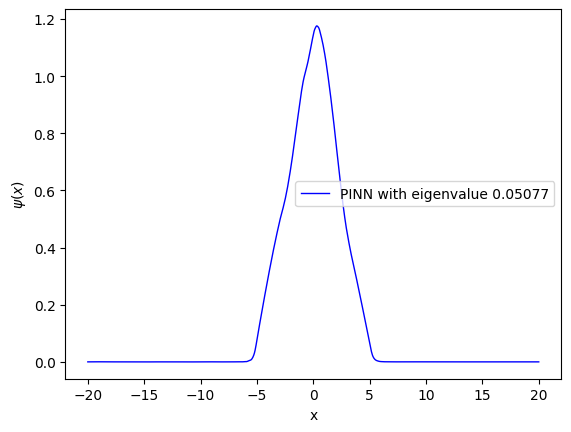

In [ ]:
fig, ax1 = plt.subplots()
psi1 = parametricSolutions(tTest, qPINN_uni[0].cpu(), t0, tf, xbc).data.numpy()
ax1.plot(t_net, psi1, color='blue', linewidth=1, label=f'PINN with eigenvalue {eig_count_uni[0]:.5f}')
#ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')

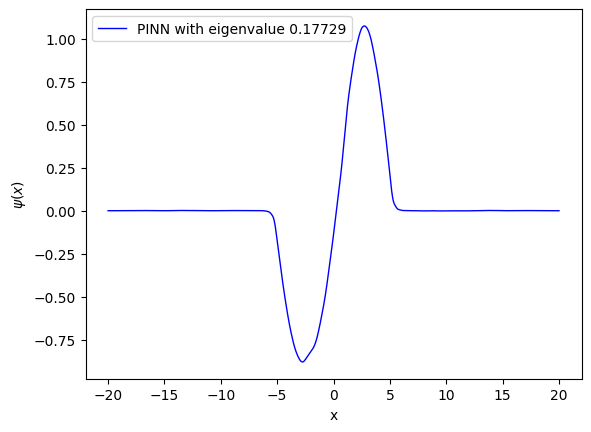

In [ ]:
fig, ax1 = plt.subplots()
psi2 = parametricSolutions(tTest, qPINN_uni[1].cpu(), t0, tf, xbc).data.numpy()
ax1.plot(t_net, psi2, color='blue', linewidth=1, label=f'PINN with eigenvalue {eig_count_uni[1]:.5f}')
#ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')

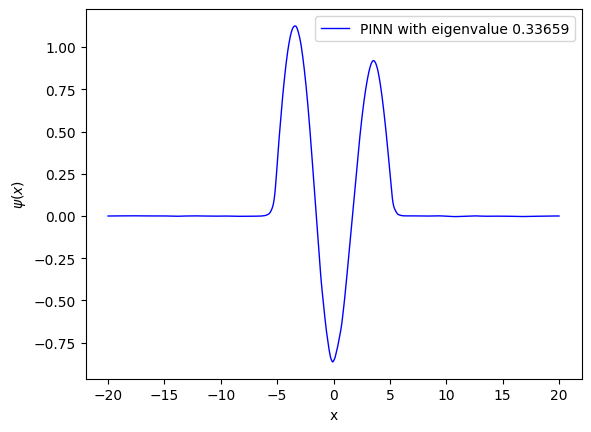

In [ ]:
fig, ax1 = plt.subplots()
psi3 = parametricSolutions(tTest, qPINN_uni[2].cpu(), t0, tf, xbc).data.numpy()
ax1.plot(t_net, psi3, color='blue', linewidth=1, label=f'PINN with eigenvalue {eig_count_uni[2]:.5f}')
#ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')

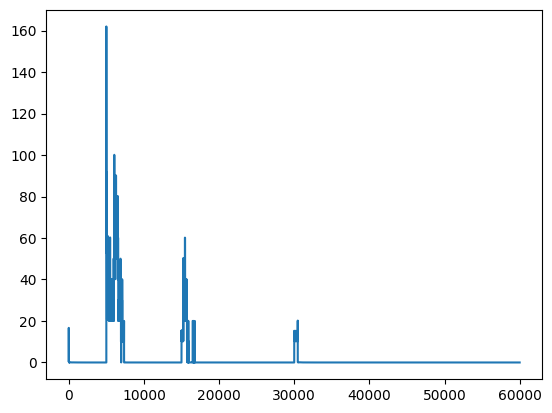

In [ ]:
plt.plot(Loss_uni)
plt.show()

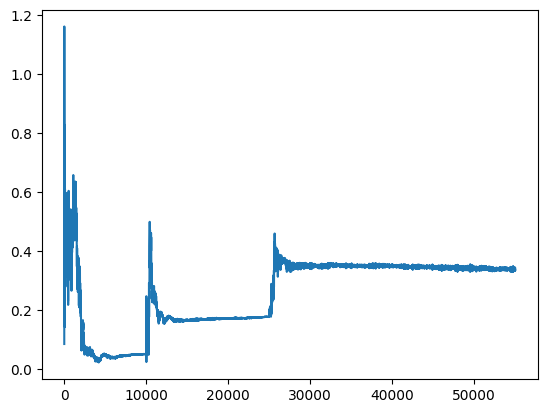

In [ ]:
plt.plot(eig_vals_uni)
plt.show()

#### Legendre Polynomial




In [ ]:
from scipy.special import p_roots
[x,_] = p_roots(col_pts)
x_legd = 20*torch.tensor(x).view(-1,1)

In [ ]:
model_legd = qNN(layers).to(device)
print(model_legd )
betas = [0.999, 0.9999]
optimizer = optim.Adam(model_legd.parameters(), lr=lr, betas=betas)

qNN(
  (activation): sine()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=25, bias=True)
    (1): Linear(in_features=25, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)


In [ ]:
name = 'legendre.pth.tar'
Loss_legd, eig_vals_legd, eig_count_legd, qPINN_legd = nn_train(model_legd,t0,tf,xbc,col_pts,breakpoints,epochs,x_legd,name)

--------------------------------------------
Epoch:  0
loss =  0.8223492497481764
--------------------------------------------
Epoch:  300
loss =  0.0068990803768966885
--------------------------------------------
Epoch:  600
loss =  0.004033686148727027
--------------------------------------------
Epoch:  900
loss =  0.0022271773564774937
--------------------------------------------
Epoch:  1200
loss =  0.0016201786476522167
--------------------------------------------
Epoch:  1500
loss =  0.0012137874908507234
--------------------------------------------
Epoch:  1800
loss =  0.0007337437142833995
--------------------------------------------
Epoch:  2100
loss =  0.0004822814234357736
--------------------------------------------
Epoch:  2400
loss =  0.00036066866852048227
--------------------------------------------
Epoch:  2700
loss =  0.0002622044375488755
--------------------------------------------
Epoch:  3000
loss =  0.00019826088811188627
----------------------------------------

KeyboardInterrupt: 

In [ ]:
checkpoint = torch.load('legendre.pth.tar')
#qNN.load_state_dict(checkpoint['state_dict']); optimizer.load_state_dict(checkpoint['optimizer'])
current = checkpoint['epoch']; orth_counter = checkpoint['orth_counter']; Loss_hist = checkpoint['Loss_hist']
En_history = checkpoint['En_history'];dic = checkpoint['dic']; En_counter = checkpoint['En_counter']

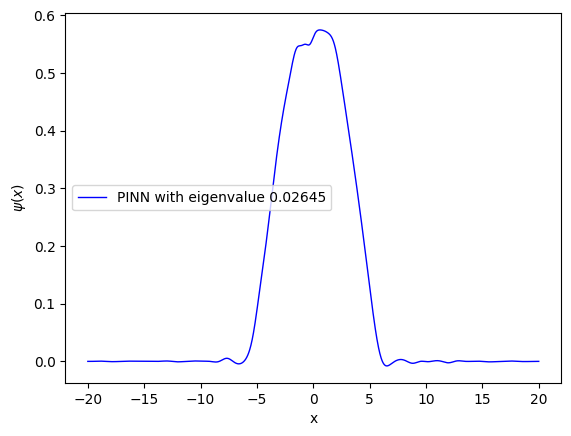

In [ ]:
fig, ax1 = plt.subplots()
psi5 = parametricSolutions(tTest, dic[0].cpu(), t0, tf, xbc).data.numpy()
ax1.plot(t_net, psi5, color='blue', linewidth=1, label=f'PINN with eigenvalue {En_counter[0]:.5f}')
#ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')

#### Cheybyshev polynomial

In [ ]:
import scipy.special as sp
x, _ = sp.roots_chebyt(col_pts)
x_cheb = 20*torch.tensor(x).view(-1,1)

In [ ]:
model_cheb= qNN(layers).to(device)
print(model_cheb )
betas = [0.999, 0.9999]
optimizer = optim.Adam(model_cheb.parameters(), lr=lr, betas=betas)

qNN(
  (activation): sine()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=25, bias=True)
    (1): Linear(in_features=25, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)


In [ ]:
name = 'cheybyshev.pth.tar'
Loss_cheb, eig_vals_cheb, eig_count_cheb, qPINN_cheb = nn_train(model_cheb,t0,tf,xbc,col_pts,breakpoints,epochs,x_cheb,name)

--------------------------------------------
Epoch:  0
loss =  0.7800491749498012
--------------------------------------------
Epoch:  300
loss =  0.010795314752071745
--------------------------------------------
Epoch:  600
loss =  0.0019986308051231612
--------------------------------------------
Epoch:  900
loss =  0.002659596327098579
--------------------------------------------
Epoch:  1200
loss =  0.0011110874650749406
--------------------------------------------
Epoch:  1500
loss =  0.0007647665901548669
--------------------------------------------
Epoch:  1800
loss =  0.0007038236413391912
--------------------------------------------
Epoch:  2100
loss =  0.0005096007338470061
--------------------------------------------
Epoch:  2400
loss =  0.0003592766544062525
--------------------------------------------
Epoch:  2700
loss =  0.00019321302495879433
--------------------------------------------
Epoch:  3000
loss =  0.0001678539869314103
------------------------------------------

KeyboardInterrupt: 

In [ ]:
checkpoint = torch.load('cheybyshev.pth.tar')
#qNN.load_state_dict(checkpoint['state_dict']); optimizer.load_state_dict(checkpoint['optimizer'])
current = checkpoint['epoch']; orth_counter = checkpoint['orth_counter']; Loss_hist = checkpoint['Loss_hist']
En_history = checkpoint['En_history'];dic = checkpoint['dic']; En_counter = checkpoint['En_counter']

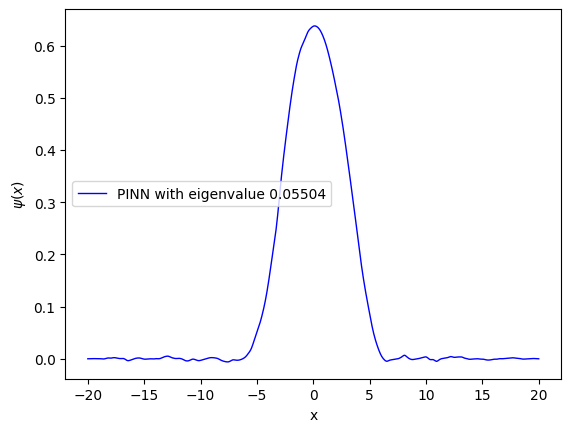

In [ ]:
fig, ax1 = plt.subplots()
psi5 = parametricSolutions(tTest, dic[0].cpu(), t0, tf, xbc).data.numpy()
ax1.plot(t_net, psi5, color='blue', linewidth=1, label=f'PINN with eigenvalue {En_counter[0]:.5f}')
#ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')

####Hermite Polynomial

In [ ]:
import scipy.special as sp

x, _ = sp.roots_hermite(col_pts)
x_herm = torch.tensor(x).view(-1,1)

In [ ]:
model_herm= qNN(layers).to(device)
print(model_herm)
betas = [0.999, 0.9999]
optimizer = optim.Adam(model_herm.parameters(), lr=lr, betas=betas)

qNN(
  (activation): sine()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [ ]:
name = 'hermite.pth.tar'
Loss_herm, eig_vals_herm, eig_count_herm, qPINN_herm = nn_train(model_herm,t0,tf,xbc,col_pts,breakpoints,epochs,x_herm,name)

--------------------------------------------
Epoch:  0
loss =  0.2988641821163784
--------------------------------------------
Epoch:  300
loss =  0.03284982761309511
--------------------------------------------
Epoch:  600
loss =  0.018751923947718373
--------------------------------------------
Epoch:  900
loss =  0.015875331784693143
--------------------------------------------
Epoch:  1200
loss =  0.010624149846203846
--------------------------------------------
Epoch:  1500
loss =  0.006607191699534216
--------------------------------------------
Epoch:  1800
loss =  0.004374968224550933
--------------------------------------------
Epoch:  2100
loss =  0.0030096825165908856
--------------------------------------------
Epoch:  2400
loss =  0.0019767203557188046
--------------------------------------------
Epoch:  2700
loss =  0.0018826345476830992
--------------------------------------------
Epoch:  3000
loss =  0.0010485811424558469
--------------------------------------------
Epo

KeyboardInterrupt: 

In [ ]:
checkpoint = torch.load('hermite.pth.tar')
#qNN.load_state_dict(checkpoint['state_dict']); optimizer.load_state_dict(checkpoint['optimizer'])
current = checkpoint['epoch']; orth_counter = checkpoint['orth_counter']; Loss_hist = checkpoint['Loss_hist']
En_history = checkpoint['En_history'];dic = checkpoint['dic']; En_counter = checkpoint['En_counter']

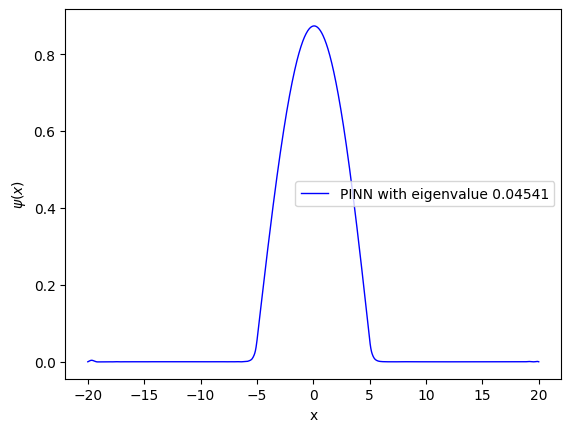

In [ ]:
fig, ax1 = plt.subplots()
psi1 = parametricSolutions(tTest, dic[0].cpu(), t0, tf, xbc).data.numpy()
ax1.plot(t_net, -psi1, color='blue', linewidth=1, label=f'PINN with eigenvalue {En_counter[0]:.5f}')
#ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')

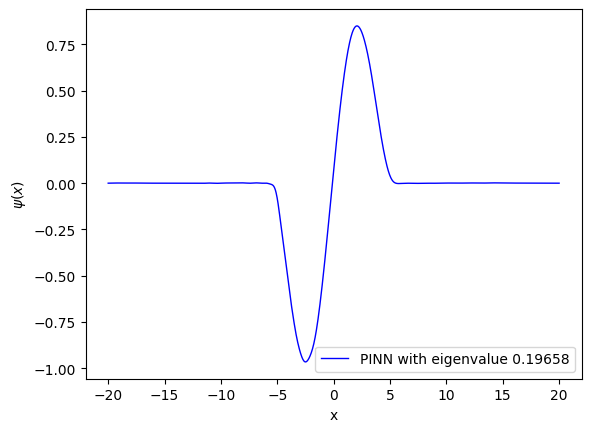

In [ ]:
fig, ax1 = plt.subplots()
psi2 = parametricSolutions(tTest, dic[1].cpu(), t0, tf, xbc).data.numpy()
ax1.plot(t_net, psi2, color='blue', linewidth=1, label=f'PINN with eigenvalue {En_counter[1]:.5f}')
#ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on